In [1]:
import torch
import matplotlib.pyplot as plt

from reconstruction_from_motion import reconstruct_from_motion_offset

/cvlabdata2/home/engilber/conda_october/lib/python3.12/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [106]:
# Dummy function to generate a heatmap with detections and offsets

def generate_heatmap_with_detections(
    hm_size=(128, 128), 
    num_detections=5,
    gaussian_sigma=2.0,
    gaussian_amplitude=1.0,
    max_offset=10.0,
    device=None
):
    """Generate a heatmap with non-overlapping Gaussian peaks representing person detections and corresponding offset map.
    
    Args:
        hm_size: Tuple of (height, width) for heatmap size
        num_detections: Number of random detections to generate
        gaussian_sigma: Standard deviation of Gaussian peaks
        gaussian_amplitude: Peak amplitude of Gaussian
        max_offset: Maximum magnitude of random offsets
        device: PyTorch device to place tensor on
        
    Returns:
        Tuple of:
            - Tensor of shape (1, 1, H, W) containing the generated heatmap
            - Tensor of shape (1, H, W, 2) containing the offset map
            - x coordinates of detections
            - y coordinates of detections
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    heatmap = torch.zeros((1, 1, hm_size[0], hm_size[1]), device=device)
    offsetmap = torch.zeros((1, hm_size[0], hm_size[1], 2), device=device)
    
    min_dist = int(4 * gaussian_sigma)
    
    x_coords = []
    y_coords = []
    max_attempts = 1000
    attempts = 0
    
    while len(x_coords) < num_detections and attempts < max_attempts:
        x = torch.randint(0, hm_size[1], (1,), device=device).item()
        y = torch.randint(0, hm_size[0], (1,), device=device).item()
        
        valid_point = True
        for prev_x, prev_y in zip(x_coords, y_coords):
            if ((x - prev_x)**2 + (y - prev_y)**2) < min_dist**2:
                valid_point = False
                break
                
        if valid_point:
            x_coords.append(x)
            y_coords.append(y)
        
        attempts += 1
    
    x_coords = torch.tensor(x_coords, device=device)
    y_coords = torch.tensor(y_coords, device=device)
    
    offsets = torch.randn(len(x_coords), 2, device=device) * max_offset
    
    y_grid, x_grid = torch.meshgrid(
        torch.arange(hm_size[0], device=device),
        torch.arange(hm_size[1], device=device)
    )
    
    for (x, y), (offset_x, offset_y) in zip(zip(x_coords, y_coords), offsets):
        gaussian = gaussian_amplitude * torch.exp(
            -((x_grid - x)**2 + (y_grid - y)**2) / (2 * gaussian_sigma**2)
        )
        heatmap[0, 0] += gaussian
        
        radius = int(gaussian_sigma * 2)
        y_min = max(0, y - radius)
        y_max = min(hm_size[0], y + radius + 1)
        x_min = max(0, x - radius)
        x_max = min(hm_size[1], x + radius + 1)
        
        offsetmap[0, y_min:y_max, x_min:x_max, 0] = offset_x
        offsetmap[0, y_min:y_max, x_min:x_max, 1] = offset_y
    
    heatmap = torch.clamp(heatmap, 0, 1)
    
    return heatmap, offsetmap, x_coords, y_coords


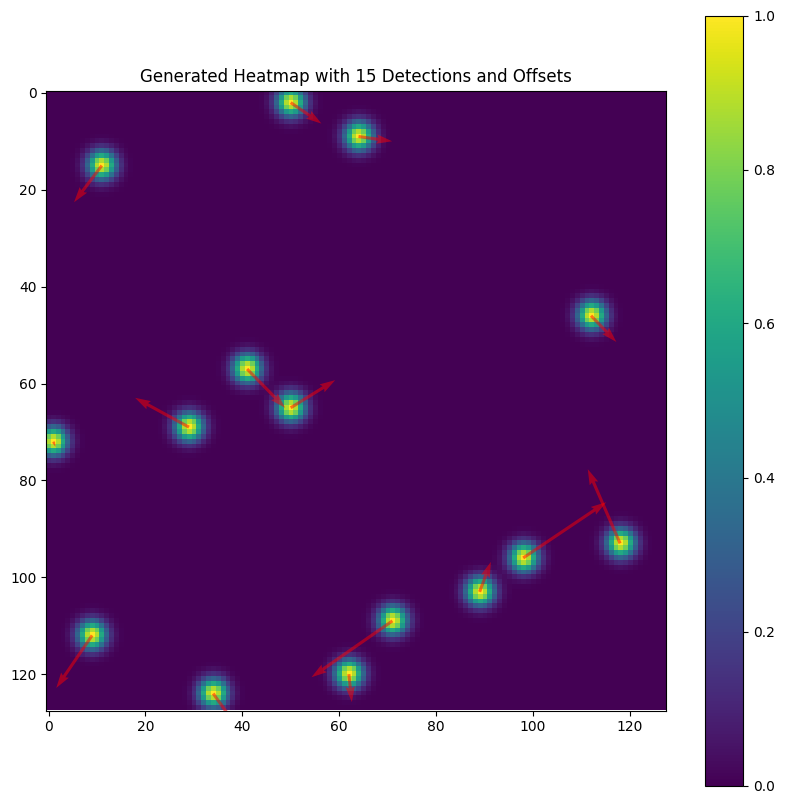

In [110]:
hm_size = (128, 128)  # Size of heatmap
num_dets = 15         # Number of detections
sigma = 2.0           # Gaussian spread
amplitude = 1.0       # Peak intensity
max_offset = 10.0     # Maximum offset magnitude

# Generate sample heatmap and offset map
sample_heatmap, sample_offsetmap, x_coords, y_coords = generate_heatmap_with_detections(
    hm_size=hm_size,
    num_detections=num_dets, 
    gaussian_sigma=sigma,
    gaussian_amplitude=amplitude,
    max_offset=max_offset
)


# Visualize the heatmap and offsets
plt.figure(figsize=(10,10))

plt.imshow(sample_heatmap[0,0].cpu())
plt.colorbar()

plt.quiver(
    x_coords.cpu(),
    y_coords.cpu(), 
    sample_offsetmap[0, y_coords, x_coords, 0].cpu(),
    sample_offsetmap[0, y_coords, x_coords, 1].cpu(),
    angles='xy',
    scale_units='xy',
    scale=1, 
    color='red',
    width=0.005,
    alpha=0.5
)

plt.title(f'Generated Heatmap with {num_dets} Detections and Offsets')
plt.show()

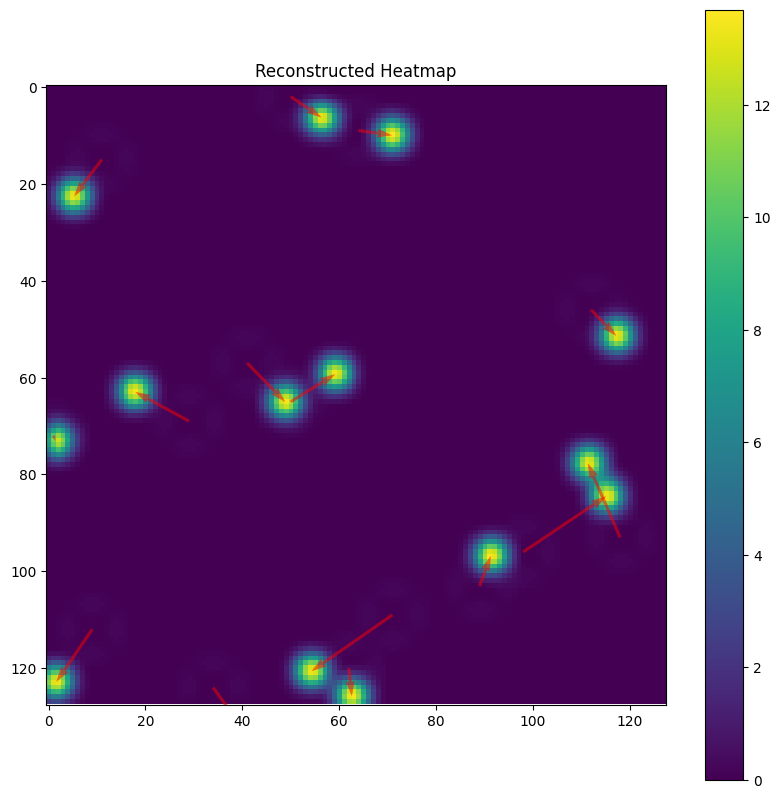

In [113]:
# Lower expe weight creates a more blurry heatmap but facilitates gradient descent

reconstructed_heatmap = reconstruct_from_motion_offset(sample_heatmap, sample_offsetmap, ksize=59, expe_weight=1)

# Visualize the reconstructed heatmap
plt.figure(figsize=(10,10))
plt.imshow(reconstructed_heatmap.squeeze().cpu())
plt.colorbar()

# Plot arrows at detection coordinates
plt.quiver(
    x_coords.cpu(),
    y_coords.cpu(), 
    sample_offsetmap[0, y_coords, x_coords, 0].cpu(),
    sample_offsetmap[0, y_coords, x_coords, 1].cpu(),
    angles='xy',
    scale_units='xy',
    scale=1, 
    color='red',
    width=0.005,
    alpha=0.5
)

plt.title('Reconstructed Heatmap with Expe Weight 1')
plt.show()




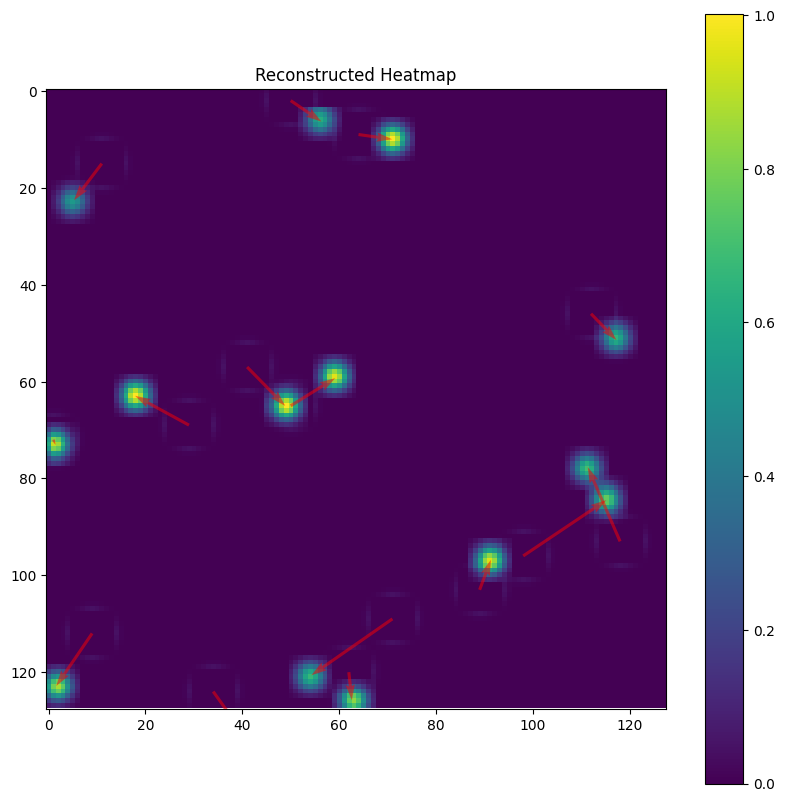

In [114]:
# Higher expe weight creates a sharper heatmap but makes gradient descent slower

reconstructed_heatmap = reconstruct_from_motion_offset(sample_heatmap, sample_offsetmap, ksize=59, expe_weight=5)

# Visualize the reconstructed heatmap
plt.figure(figsize=(10,10))
plt.imshow(reconstructed_heatmap.squeeze().cpu())
plt.colorbar()

# Plot arrows at detection coordinates
plt.quiver(
    x_coords.cpu(),
    y_coords.cpu(), 
    sample_offsetmap[0, y_coords, x_coords, 0].cpu(),
    sample_offsetmap[0, y_coords, x_coords, 1].cpu(),
    angles='xy',
    scale_units='xy',
    scale=1, 
    color='red',
    width=0.005,
    alpha=0.5
)

plt.title('Reconstructed Heatmap with Expe Weight 5')
plt.show()